In [1]:
import numpy as np
from qiskit.quantum_info import random_statevector

# 2 Qubits

In [2]:
n_qubits = 2

### Generate "unkown" state you want to learn

In [3]:
psi = random_statevector(2**n_qubits).data.reshape(-1, 1)
unkown_dm = psi @ psi.conj().T

### Define measurement bases 

In [4]:
measurement_strings = ["0", "1", "+", "-", "i", "-i"]

zero = np.array([1, 0]).reshape(-1, 1)
one = np.array([0, 1]).reshape(-1, 1)
plus = 1/np.sqrt(2) * np.array([1, 1]).reshape(-1, 1)
minus = 1/np.sqrt(2) * np.array([1, -1]).reshape(-1, 1)
i = 1/np.sqrt(2) * np.array([1, 1j]).reshape(-1, 1)
minus_i = 1/np.sqrt(2) * np.array([1, -1j]).reshape(-1, 1)

basis_states = [zero, one, plus, minus, i, minus_i]

### Create measurement projectors

In [5]:
# 2 qubits
measurement_operators = [state_vector @ state_vector.conj().T for state_vector in basis_states]
two_qubit_measurement_operators = []
for qubit_1_op in measurement_operators:
    for qubit_2_op in measurement_operators:
        two_qubit_measurement_operators.append(np.kron(qubit_1_op, qubit_2_op))

### Compute probabilities to use as the data to fit to
Experimentally, you would compute these from measurement counts

In [6]:
def get_probabilities(dm):
    return [np.trace(dm @ measurement_op).real for measurement_op in two_qubit_measurement_operators]

probabilities = get_probabilities(unkown_dm)
prob_dict = dict(zip(measurement_strings, probabilities))

### Create tunable state
Parameterization from: https://research.physics.illinois.edu/QI/Photonics/tomography-files/tomo_chapter_2004.pdf

In [7]:
def get_parameterized_dm(t):
    """ t is a list of the tunable parameters """
    T = np.array([[t[0], 0, 0, 0],
                  [t[4] + 1j*t[5], t[1], 0, 0],
                  [t[10] + 1j*t[11], t[6] + 1j*t[7], t[2], 0],
                  [t[14] + 1j*t[15], t[12] + 1j*t[13], t[8] + 1j*t[9], t[3]]
                 
                 ])
    parameterized_rho = (T.conj().T @ T) / np.trace(T.conj().T @ T)
    return parameterized_rho

In [8]:
dm_parameters = np.random.uniform(low=-1, high=1, size=16)

In [9]:
parameterized_dm = get_parameterized_dm(dm_parameters)

### Test that DM is valid

In [10]:
# Check that trace is close to one
assert np.allclose(1, np.trace(parameterized_dm))

# Check Hermitian
assert np.allclose(parameterized_dm, parameterized_dm.conj().T)

# Check positive-semi definite <--> eigenvalues >= 0
assert np.all(np.linalg.eigvalsh(parameterized_dm) >= 0)

### Optimize with SciPy

In [11]:
def get_probabilites_from_parameters(t):
    parameterized_dm = get_parameterized_dm(t)
    probabilities = get_probabilities(parameterized_dm)
    return probabilities

In [12]:
from scipy.special import kl_div

def kl_divergence(true_probs, t):
    probs = get_probabilites_from_parameters(t)
    return sum(kl_div(true_probs, probs))

kl_divergence_from_parameters = lambda params : kl_divergence(probabilities, params)

In [13]:
from scipy.optimize import minimize

optimization_result = minimize(kl_divergence_from_parameters, dm_parameters, method="L-BFGS-B")

In [14]:
found_params = optimization_result.x

found_dm = get_parameterized_dm(found_params)

In [15]:
dm_fidelity = lambda d1, d2 : np.trace(d1.T.conj() @ d2).real

dm_fidelity(unkown_dm, found_dm)

0.9997796368346651

In [16]:
print(unkown_dm)

[[ 0.29106489-5.88067052e-18j -0.40536134-8.59899740e-02j
   0.11735878+1.26237562e-01j  0.04676288-5.23283713e-02j]
 [-0.40536134+8.59899740e-02j  0.58994436-3.96344520e-19j
  -0.20073832-1.41137422e-01j -0.0496664 +8.66921359e-02j]
 [ 0.11735878-1.26237562e-01j -0.20073832+1.41137422e-01j
   0.10207004-6.62271517e-19j -0.00384028-4.13805501e-02j]
 [ 0.04676288+5.23283713e-02j -0.0496664 -8.66921359e-02j
  -0.00384028+4.13805501e-02j  0.01692071+1.72932884e-19j]]


In [17]:
print(found_dm)

[[ 0.29104013-1.74793324e-18j -0.40528664-8.59271610e-02j
   0.11729283+1.26177355e-01j  0.04664478-5.22725502e-02j]
 [-0.40528664+8.59271610e-02j  0.58989636+4.77518295e-18j
  -0.20063033-1.41121562e-01j -0.04956373+8.66338415e-02j]
 [ 0.11729283-1.26177355e-01j -0.20063033+1.41121562e-01j
   0.10206416-2.64878206e-18j -0.00388927-4.13940609e-02j]
 [ 0.04664478+5.22725502e-02j -0.04956373-8.66338415e-02j
  -0.00388927+4.13940609e-02j  0.01699935-3.78467654e-19j]]


### Plot Density Matrices

In [18]:
import matplotlib as mplt
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
def bar_plot_3d(top, title=""):
    # set up the figure and axes
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(121, projection='3d')

    x_dim = y_dim = len(top)
    
    # fake data
    _x = np.arange(x_dim)
    _y = np.arange(y_dim)
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()

    # top = x + y

    bottom = np.zeros_like(top)
    width = depth = 0.5

    ax.bar3d(x, y, bottom.flatten(), width, depth, top.flatten(), shade=True)
    ax.set_title(title)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xlabel("row")
    ax.set_ylabel("column")


    plt.show()

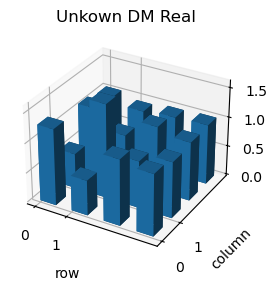

[[1.29106489 0.59463866 1.11735878 1.04676288]
 [0.59463866 1.58994436 0.79926168 0.9503336 ]
 [1.11735878 0.79926168 1.10207004 0.99615972]
 [1.04676288 0.9503336  0.99615972 1.01692071]]


In [20]:
bar_plot_3d(unkown_dm.real + 1, title="Unkown DM Real")
print(unkown_dm.real + 1)

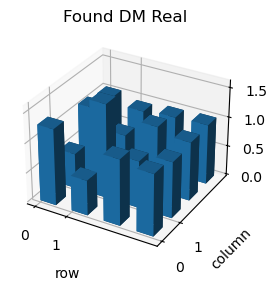

[[1.29104013 0.59471336 1.11729283 1.04664478]
 [0.59471336 1.58989636 0.79936967 0.95043627]
 [1.11729283 0.79936967 1.10206416 0.99611073]
 [1.04664478 0.95043627 0.99611073 1.01699935]]


In [21]:
bar_plot_3d(found_dm.real + 1, title="Found DM Real")
print(found_dm.real + 1)

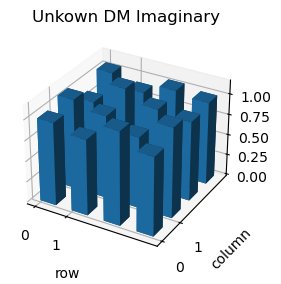

[[1.         0.91401003 1.12623756 0.94767163]
 [1.08598997 1.         0.85886258 1.08669214]
 [0.87376244 1.14113742 1.         0.95861945]
 [1.05232837 0.91330786 1.04138055 1.        ]]


In [22]:
bar_plot_3d(unkown_dm.imag + 1, title="Unkown DM Imaginary")
print(unkown_dm.imag + 1)

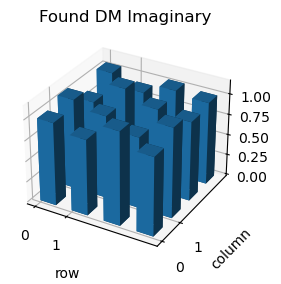

[[1.         0.91407284 1.12617736 0.94772745]
 [1.08592716 1.         0.85887844 1.08663384]
 [0.87382264 1.14112156 1.         0.95860594]
 [1.05227255 0.91336616 1.04139406 1.        ]]


In [23]:
bar_plot_3d(found_dm.imag + 1, title="Found DM Imaginary")
print(found_dm.imag + 1)